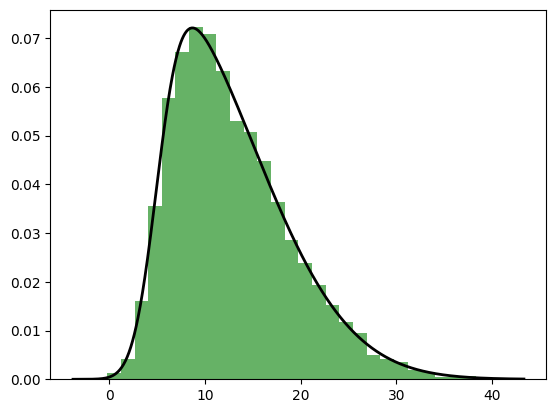

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skewnorm
import tensorflow as tf

# Define the number of samples, the location, the scale, and the skewness
num_samples = 10000
mu_data = 5.0  # location (mean) 
sd_data = 10.0  # scale (standard deviation) 
alpha_data = 5.0  # skewness (negative value means left skew, positive means right skew)

# Generate samples from the skew normal distribution
dist = skewnorm(alpha_data, mu_data, sd_data)
samples = dist.rvs(num_samples)
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
# xmin = xmin + 1/7 * (xmax - xmin)
x = np.linspace(xmin, xmax, 1000)
p = skewnorm.pdf(x, alpha_data, mu_data, sd_data)
plt.plot(x, p, 'k', linewidth=2)
x_values = x 
y_values = p
plt.show()

In [3]:
# import tensorflow as tf

# class SkewNormalLayer(tf.keras.layers.Layer):
#     def __init__(self, num_outputs):
#         super(SkewNormalLayer, self).__init__()

#     def call(self, inputs):
#         x, mu, sd, alpha = inputs
#         x_skew = x + mu * alpha / sd
#         sigma = sd * np.exp(-alpha)
#         sn_dist = tf.distributions.SkewNormal(x_skew, sigma)
#         return sn_dist.sample()

In [4]:
import tensorflow as tf

class MuSDAlphaLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MuSDAlphaLayer, self).__init__(**kwargs)
        # Define three separate dense layers for mu, sd, and alpha
        self.dense_mu = tf.keras.layers.Dense(1, name='mu')
        self.dense_sd = tf.keras.layers.Dense(1, name='sd')
        self.dense_alpha = tf.keras.layers.Dense(1, name='alpha')

    def call(self, x):
        # Compute mu, sd, and alpha
        mu = self.dense_mu(x)
        sd = self.dense_sd(x)
        alpha = self.dense_alpha(x)
        # Ensure that standard deviation (sd) is non-negative
        sd = tf.keras.activations.relu(sd)
        return mu, sd, alpha


In [5]:
import tensorflow as tf

class SkewNormalLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SkewNormalLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Unpack the inputs (assuming inputs = [x_values, mu, sd, alpha])
        x_values, mu, sd, alpha = inputs
        
        # Ensure sd is positive to avoid division by zero
        sd = tf.keras.activations.relu(sd) + tf.keras.backend.epsilon()

        # Compute the skew normal distribution
        # Note: This is a simplified example. You may need to implement a more
        #       accurate computation based on the skew normal distribution formula.
        norm_pdf = (1 / (sd * tf.sqrt(2 * tf.constant(np.pi)))) * \
                   tf.exp(-0.5 * ((x_values - mu) / sd) ** 2)
        norm_cdf = 0.5 * (1 + tf.math.erf(alpha * (x_values - mu) / (sd * tf.sqrt(2))))
        skew_norm_pdf = 2 * norm_pdf * norm_cdf

        return skew_norm_pdf

    # Optionally, you can implement the `compute_output_shape` method if you need to
    # specify the shape of the output tensor.


In [7]:
print(tf.__version__)

2.16.1


In [8]:
import tensorflow as tf
import tensorflow_probability as tfp

class SkewNormalLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SkewNormalLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Unpack the inputs (assuming inputs = [x_values, mu, sd, alpha])
        x_values, mu, sd, alpha = inputs
        
        # Ensure sd is positive to avoid division by zero
        sd = tf.keras.activations.relu(sd) + tf.keras.backend.epsilon()

        # Create skew normal distribution using TFP
        skew_normal_dist = tfp.distributions.TwoPieceNormal(loc=mu, scale=sd, skewness=alpha)

        # Compute the probability density function (PDF) of skew normal distribution
        skew_norm_pdf = skew_normal_dist.prob(x_values)

        return skew_norm_pdf

# # Example usage in a model
# x_values = tf.keras.Input(shape=(1,))
# mu, sd, alpha = MuSDAlphaLayer()(previous_layer_output)
# skew_normal_output = SkewNormalLayer()([x_values, mu, sd, alpha])
# model = tf.keras.Model(inputs=[x_values, previous_layer_input], outputs=skew_normal_output)


ValueError: Arg specs do not match: original=FullArgSpec(args=['input', 'dtype', 'name', 'layout'], varargs=None, varkw=None, defaults=(None, None, None), kwonlyargs=[], kwonlydefaults=None, annotations={}), new=FullArgSpec(args=['input', 'dtype', 'name'], varargs=None, varkw=None, defaults=(None, None), kwonlyargs=[], kwonlydefaults=None, annotations={}), fn=<function ones_like_v2 at 0x7f902d16fc70>

In [ ]:
# Assuming you have the outputs mu, sd, alpha from the previous layer
# and an input tensor x_values representing the x-values for the distribution
x_values = tf.keras.Input(shape=(1,))
mu, sd, alpha = MuSDAlphaLayer()(previous_layer_output)

# Create the SkewNormalLayer and pass the required inputs
skew_normal_output = SkewNormalLayer()([x_values, mu, sd, alpha])

# Create the model
model = tf.keras.Model(inputs=[x_values, previous_layer_input], outputs=skew_normal_output)


In [14]:
# Create a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    MuSDAlphaLayer(64),
    SkewNormalLayer(64),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Train and evaluate the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_values, y_values, epochs=10)
# model.evaluate(X_test, Y_test)

Epoch 1/10


ValueError: Input 0 of layer "dense_3" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)

In [2]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [3]:
def skew_norm_pdf(x, location, scale, shape):
    # Standardize the input
    t = (x - location) / scale

    # PDF of the standard normal distribution
    pdf = tf.exp(-t**2 / 2) / np.sqrt(2*np.pi)

    # CDF of the standard normal distribution
    cdf = 0.5 * (1 + tf.math.erf(shape * t / np.sqrt(2)))

    return 2 * pdf * cdf

class OutputNeuron(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x, mu, sd, alpha):
        # return skew_norm_pdf(x, mu, sd, alpha)
        x_skew = x + mu * alpha / sd
        sigma = sd * np.exp(-alpha)
        sn_dist = tf.distributions.SkewNormal(x_skew, sigma)
        return sn_dist.sample()

In [11]:
class SNRegressor(tf.keras.Model):
    def __init__(self, x, **kwargs):
        super().__init__(**kwargs)
        self.denseBlock1 = MyDense(30, activation='relu')
        self.denseBlock2 = MyDense(30, activation='relu')
        self.mu = MyDense(1)
        self.sd = MyDense(1, activation='softplus')
        self.alpha = MyDense(1)
        self.outputNeuron = OutputNeuron()
        self.x = x
        # self.out = tf.keras.layers.Dense(output_dim)

    def call(self, input):
        Z = self.denseBlock1(input)
        Z = self.denseBlock2(Z)
        mu = self.mu(Z)
        sd = self.sd(Z)
        # print(sd)
        alpha = self.alpha(Z)
        return self.outputNeuron(self.x, mu, sd, alpha)
    
    def get_params(self, input):
        Z = self.denseBlock1(input)
        Z = self.denseBlock2(Z)
        mu = self.mu(Z)
        sd = self.sd(Z)
        alpha = self.alpha(Z)
        return mu, sd, alpha

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_values_reshaped = x_values.reshape(-1,1)
y_values_reshaped = y_values.reshape(-1,1)
X_train_scaled = scaler.fit_transform(x_values_reshaped)

In [13]:
tf.keras.utils.set_random_seed(42)
model = SNRegressor(x_values)
model.compile(loss='mse', optimizer='adam')
model.fit(X_train_scaled, y_values_reshaped, epochs=10, batch_size=32)
# model.summary()

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0040
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 


In [14]:
mu, sd, alpha = model.get_params(X_train_scaled)

In [15]:
print('mu:', tf.reduce_mean(mu))
print('sd:', tf.reduce_mean(sd))
print('alpha:', tf.reduce_mean(alpha))

mu: tf.Tensor(-0.9460036, shape=(), dtype=float32)
sd: tf.Tensor(0.0038258166, shape=(), dtype=float32)
alpha: tf.Tensor(0.020104993, shape=(), dtype=float32)


In [16]:
predictions = skewnorm.pdf(x_values, np.mean(alpha), np.mean(mu), np.mean(sd))

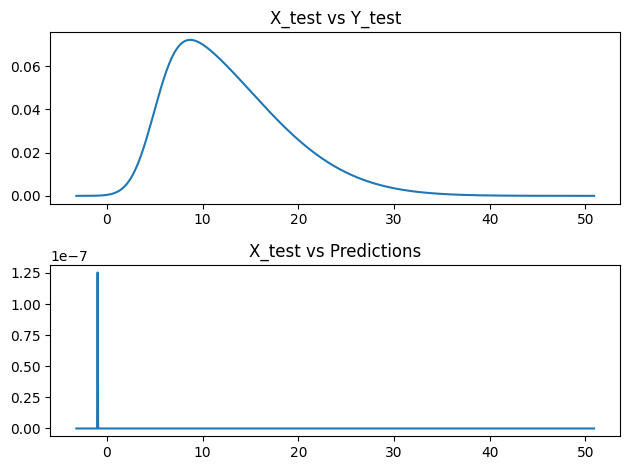

In [17]:
plt.figure()
# Create the first subplot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(x_values, y_values)
plt.title('X_test vs Y_test')

# Create the second subplot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.plot(x_values, predictions)
plt.title('X_test vs Predictions')

# Display the plots
plt.tight_layout()
plt.show()

2024-03-22 00:46:56.118639: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 00:46:57.181188: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 00:46:59.888007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 00:47:02.746720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
